## Batch opening IMOS Data

In [5]:
import urllib
import io, re
import numpy as np
import struct
import matplotlib.pyplot as plt

In [8]:
# Function to read binary data and fetch header
def ReadBinaryFile(url):
    with urllib.request.urlopen(url) as f:
        data = f.readlines()
    
    # Split binary file
    header, body, footer = data[:5], data[5:-6], data[-6:]

    # Fetch header info with # https://regex101.com/
    header = [h.decode() for h in header]
    match = re.match('Sample Rate ([0-9]*) Duration ([0-9]*)', header[2])
    SampleRate = int(match.group(1))
    Duration = int(match.group(2))
    match = re.match('Schedule [0-9]* ([0-9]{4})\/([0-9]{2})\/([0-9]{1,2}) ([0-9:]*) - ([0-9]*)', header[1])
    match.groups()

    # Read binaries
    list_of_bytes = [bytes(element) for element in body]
    list_of_bytes = b'<\>'.join(list_of_bytes)
    new_body = []

    for i, l in enumerate(body):
        if len(l)%2 == 1:
            #print(l, i)
            l = l[:-1]
        string_formatter = '>' + ('H' * (len(l) // 2))
        temp = struct.unpack(string_formatter, l)
        new_body.extend(temp)
    
    volts = np.array(new_body)
    
    return volts, Duration, SampleRate

In [15]:
url = 'https://imos-data.aodn.org.au/IMOS/ANMN/Acoustic/PAPCA/3444/20161002/raw/57F04DF1.DAT'
Volts, duration, SampleRate = ReadBinaryFile(url)

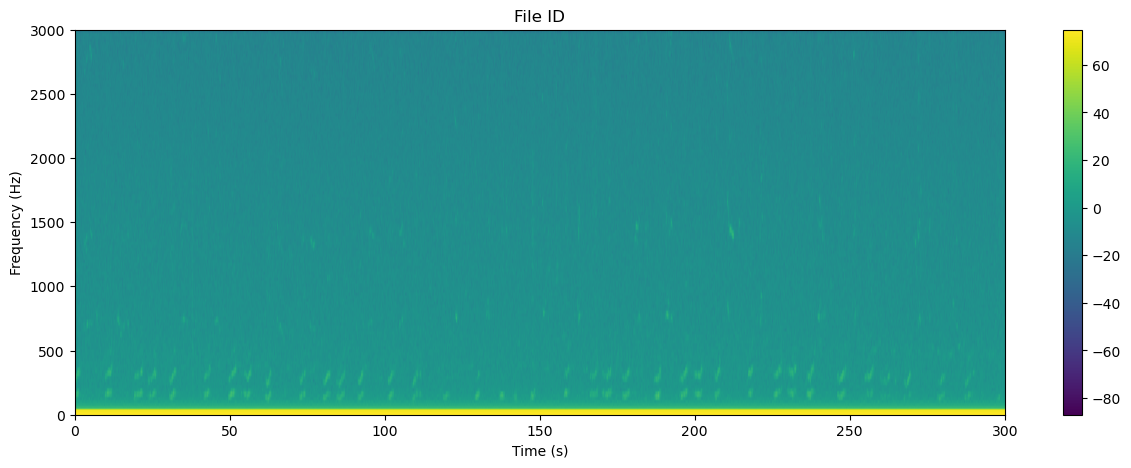

In [16]:
# Plot spectrogram
plt.figure(figsize=(15, 5))
plt.specgram(Volts, Fs=SampleRate)
plt.title('File ID')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, duration)
plt.colorbar()
plt.show()